In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 0
#from anndata import AnnData
import scipy
#from numpy.linalg import svd


import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), 'Documents/git/Xct'))

    from scTenifoldXct.main import *
    import scTenifoldXct.dNN as dNN    
    import scTenifoldXct.visualization as vis
    
except ImportError:
    print('Module not found')

In [3]:
ada = sc.read_h5ad("../data/HCC_processed_v2.h5ad")
ada

AnnData object with n_obs × n_vars = 4096 × 2608
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'patient_id', 'patient_tumorsection', 'NormalvsTumor', 'patientno', 'PNC', 'PIC', 'ViralvsNonViral', 'ident', 'batch'
    var: 'gene_ids', 'n_cells'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p', 'raw'

In [ ]:
#ada.obs.rename({'indent': 'ident'}, axis=1, inplace=True)

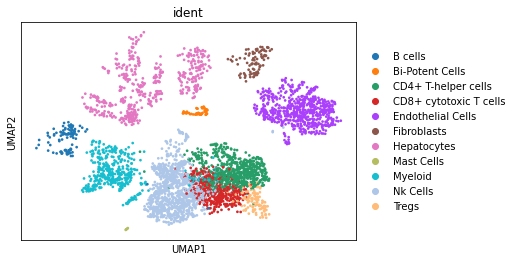

In [4]:
sc.pl.umap(ada, color='ident')

In [5]:
ada_N = ada[ada.obs['NormalvsTumor'] == 'N', :].copy()
ada_T = ada[ada.obs['NormalvsTumor'] == 'T', :].copy()
ada_N.shape, ada_T.shape

((2057, 2608), (2039, 2608))

In [6]:
ada_T.obs['ident'].value_counts()

Hepatocytes               462
CD4+ T-helper cells       422
CD8+ cytotoxic T cells    273
Endothelial Cells         272
Nk Cells                  221
Myeloid                   189
Tregs                      99
Fibroblasts                59
B cells                    39
Mast Cells                  2
Bi-Potent Cells             1
Name: ident, dtype: int64

In [7]:
ada_N.obs['ident'].value_counts()

Nk Cells                  801
Endothelial Cells         386
CD4+ T-helper cells       260
Myeloid                   225
CD8+ cytotoxic T cells    191
B cells                    65
Bi-Potent Cells            53
Fibroblasts                36
Tregs                      19
Hepatocytes                18
Mast Cells                  3
Name: ident, dtype: int64

## tumor vs adjacent normal:

In [8]:
# obj_T = Xct(ada_T, 'Hepatocytes', 'Endothelial Cells', build_GRN = True, save_GRN = True, 
#           pcNet_name = 'Net_Hep2Endo_T', mode = 'full', verbose=True)

obj_T = Xct(ada_T, 'Hepatocytes', 'Endothelial Cells', build_GRN = False,
           pcNet_name = 'Net_Hep2Endo_T')

print(obj_T)

Xct object for interactions from Hepatocytes (462) to Endothelial Cells (272)
# of genes = 2608 X 2608 
Correspondence = 5216 X 5216


In [9]:
df1_T = obj_T.fill_metric()
df1_T

,ligand,receptor,mean_L,mean_R,var_L,var_R
186,NID1,PTPRF,0.033262,0.005097,0.025957,0.003507
271,IL1B,PLAUR,0.001500,0.036930,0.001038,0.032931
274,KNG1,PLAUR,0.523149,0.036930,0.689779,0.032931
275,VTN,PLAUR,1.317913,0.036930,2.115814,0.032931
276,PLG,PLAUR,0.148717,0.036930,0.169688,0.032931
...,...,...,...,...,...,...
7967,ANGPTL4,GPIHBP1,0.092515,0.040536,0.083921,0.033514
7979,S100A8,CD68,0.001500,0.005097,0.001038,0.003507
7980,S100A9,CD68,0.055646,0.005097,0.113773,0.003507
7984,TF,TFR2,0.697570,0.002548,0.913951,0.001760


In [19]:
# obj1_N = Xct(ada_N, 'Hepatocytes', 'Endothelial Cells', build_GRN = True, save_GRN = True, 
#           pcNet_name = 'Net_Hep2Endo_N', mode = 'full', verbose=True)


obj_N = Xct(ada_N, 'Hepatocytes', 'Endothelial Cells', build_GRN = False,
           pcNet_name = 'Net_Hep2Endo_N')

print(obj_N)

Xct object for interactions from Hepatocytes (18) to Endothelial Cells (386)
# of genes = 2608 X 2608 
Correspondence = 5216 X 5216


In [11]:
df1_N = obj_N.fill_metric()
df1_N

,ligand,receptor,mean_L,mean_R,var_L,var_R
274,KNG1,PLAUR,0.138050,0.113438,0.101378,0.103768
275,VTN,PLAUR,0.495614,0.113438,0.467505,0.103768
276,PLG,PLAUR,0.077016,0.113438,0.047452,0.103768
375,APOE,APP,0.276101,0.375405,0.164641,0.243506
393,IGF2,PDGFRB,0.099542,0.024354,0.083836,0.028555
...,...,...,...,...,...,...
7440,SAA1,SCARB1,0.381496,0.016161,0.363564,0.010941
7442,APOE,SCARB1,0.276101,0.016161,0.164641,0.010941
7728,HP,ASGR1,1.230502,0.010774,1.034765,0.007352
7967,ANGPTL4,GPIHBP1,0.038508,0.081515,0.025209,0.084282


In [14]:
#selected LR pairs
candidates_T = get_candidates(df1_T)
print(len(candidates_T))

candidates_N = get_candidates(df1_N)
print(len(candidates_N))

314
101


In [15]:
candidates_union = list(set(candidates_T).union(set(candidates_N)))
len(candidates_union)

337

In [16]:
candidates_inter = list(set(candidates_T).intersection(set(candidates_N)))
len(candidates_inter)

78

## mode 'full':

In [20]:
obj_T._w.shape, obj_N._w.shape

((5216, 5216), (5216, 5216))

In [22]:
counts_np1 = get_counts_np(obj_T, obj_N)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape, counts_np1[2].shape, counts_np1[3].shape

(4, (2608, 462), (2608, 272), (2608, 18), (2608, 386))

In [23]:
W = build_W(obj_T, obj_N)
W.shape

(10432, 10432)

In [24]:
projections, losses = dNN.train_and_project(counts_np1, w = W, dim = 2, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=462, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=30, bias=True)
  (linear3): Linear(in_features=30, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=272, out_features=92, bias=True)
  (linear2): Linear(in_features=92, out_features=23, bias=True)
  (linear3): Linear(in_features=23, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=18, out_features=24, bias=True)
  (linear2): Linear(in_features=24, out_features=6, bias=True)
  (linear3): Linear(in_features=6, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=386, out_features=108, bias=True)
  (linear2): Linear(in_features=108, out_features=27, bias=True)
  (linear3): Linear(in_features=27, out_features=2, bias=True)
)
1 8363.27734375
10 3620.43017578125
20 1931.6732177734375
30 1405.7698974609375
40 1009.2149047851562
50 863.4345703125
60 819.83203125
70 788.6187744140625
80 762.21923828125
90 737.8208618164062
100 71

In [25]:
projections.shape

(10432, 2)

In [26]:
projections_split = np.array_split(projections, 2) #return a list of ndarray
projections_split[0].shape, projections_split[1].shape

((5216, 2), (5216, 2))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(figsize=(12,12), dpi=80)
ax = Axes3D(fig)

ax.scatter(projections_split[0][:2608, 0], projections_split[0][:2608, 1], projections_split[0][:2608, 2], c='red')
ax.scatter(projections_split[0][2608:, 0], projections_split[0][2608:, 1], projections_split[0][2608:, 2], c='blue')

ax.scatter(projections_split[1][:2608, 0], projections_split[1][:2608, 1], projections_split[1][:2608, 2], c='black')
ax.scatter(projections_split[1][2608:, 0], projections_split[1][2608:, 1], projections_split[1][:2608, 2], c='green')

# for ii in range(0,360,30):
#     ax.view_init(elev=10., azim=ii)
#     plt.savefig("movie%d.png" % ii)

plt.show()

In [27]:
df_nn_T = nn_aligned_dist(obj_T, projections_split[0], dist_metric = 'euclidean') # euclidean, mahalanobis
df_nn_N = nn_aligned_dist(obj_N, projections_split[1], dist_metric = 'euclidean')


df_nn_T.head()

computing pair-wise euclidean distances...
adding column 'correspondence'...
computing pair-wise euclidean distances...
adding column 'correspondence'...


,ligand,receptor,dist,correspondence
FO538757.2_FO538757.2,FO538757.2,FO538757.2,0.015061,0.091134
FO538757.2_KLHL17,FO538757.2,KLHL17,0.018502,0.012171
FO538757.2_HES4,FO538757.2,HES4,0.018148,0.012171
FO538757.2_AGRN,FO538757.2,AGRN,0.011127,0.330366
FO538757.2_TNFRSF4,FO538757.2,TNFRSF4,0.010248,0.550417


In [56]:
df_nn_all = nn_aligned_dist_diff(df_nn_T, df_nn_N)

df_nn_all

computing pair-wise distance differences...
adding column 'diff2'...


,ligand,receptor,dist,correspondence,dist,correspondence,diff2
FO538757.2_FO538757.2,FO538757.2,FO538757.2,0.015061,0.091134,0.014508,0.191655,3.062088e-07
FO538757.2_KLHL17,FO538757.2,KLHL17,0.018502,0.012171,0.017755,0.000000,5.586770e-07
FO538757.2_HES4,FO538757.2,HES4,0.018148,0.012171,0.016270,0.096054,3.525445e-06
FO538757.2_AGRN,FO538757.2,AGRN,0.011127,0.330366,0.011533,0.505871,1.648670e-07
FO538757.2_TNFRSF4,FO538757.2,TNFRSF4,0.010248,0.550417,0.012383,0.450030,4.562082e-06
...,...,...,...,...,...,...,...
AL354822.1_LSS,AL354822.1,LSS,0.018945,0.005324,0.020477,0.000000,2.346141e-06
AL354822.1_MCM3AP,AL354822.1,MCM3AP,0.018530,0.005621,0.020319,0.000000,3.199201e-06
AL354822.1_C21orf58,AL354822.1,C21orf58,0.021723,0.001255,0.021638,0.000000,7.145429e-09
AL354822.1_S100B,AL354822.1,S100B,0.022785,0.000000,0.023021,0.000000,5.581663e-08


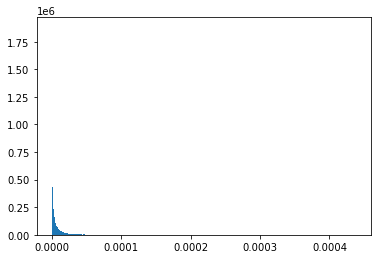

In [29]:
plt.hist(df_nn_all['diff2'], bins=1000)
plt.show()

In [57]:
df_enriched_diff = chi2_diff_test(df_nn_all, df=1, pval=0.05, FDR=True, candidates=candidates_union)
df_enriched_diff


Total enriched: 9 / 6801664


,ligand,receptor,dist,correspondence,dist,correspondence,diff2,p_val,q_val,enriched_rank,dir,dir_sign
PLA2G2A_ITGA5,PLA2G2A,ITGA5,0.000986,63.442886,0.014007,0.000000,0.000170,7.045194e-07,0.002859,1,1,↑
TFF3_ACKR3,TFF3,ACKR3,0.009251,4.894422,0.021270,0.000000,0.000144,4.685498e-06,0.006141,2,1,↑
TFF3_GHR,TFF3,GHR,0.011127,3.013985,0.022277,0.000000,0.000124,2.162887e-05,0.011022,3,1,↑
IGF2_PDGFRB,IGF2,PDGFRB,0.021538,0.002204,0.010472,1.563339,0.000122,2.497761e-05,0.011472,4,0,↓
CXCL3_ACKR1,CXCL3,ACKR1,0.006018,9.877164,0.016398,0.000000,0.000108,7.689045e-05,0.021261,5,1,↑
TFF1_GHR,TFF1,GHR,0.011917,1.686108,0.022277,0.000000,0.000107,7.928120e-05,0.021261,6,1,↑
IGF2_FGFR3,IGF2,FGFR3,0.020261,0.008800,0.010062,1.164751,0.000104,1.021817e-04,0.024371,7,0,↓
TFF2_GHR,TFF2,GHR,0.012314,1.314325,0.022277,0.000000,0.000099,1.476367e-04,0.029950,8,1,↑
MDK_ITGA6,MDK,ITGA6,0.004967,9.732614,0.014463,0.000000,0.000090,2.976836e-04,0.046438,9,1,↑


In [ ]:
# df_enriched_diff.to_excel('HCC_compare.xlsx')

#### GSEA:

In [58]:
df_enriched_up = df_enriched_diff[df_enriched_diff['dir'] == 1]

genelist = get_genelist(df_enriched_up) # saveas='heart_diff'
len(genelist)

11

In [59]:
genelist

['ACKR3',
 'TFF2',
 'ITGA6',
 'CXCL3',
 'GHR',
 'MDK',
 'ITGA5',
 'PLA2G2A',
 'TFF1',
 'TFF3',
 'ACKR1']

In [33]:
import gseapy as gp

enr = gp.enrichr(gene_list= genelist,
                 gene_sets= 'BioPlanet_2019', #'GO_Biological_Process_2021',
                 organism='Human', 
                 outdir=None, #'enrichr_kegg',
                 no_plot=True,
                 cutoff=0.05 
                )

In [34]:
enr.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,BioPlanet_2019,Trefoil factor initiation of mucosal healing,4/38,3.619627e-09,3.728216e-07,0,0,335.378151,6518.709884,GHR;TFF3;TFF2;TFF1
1,BioPlanet_2019,Beta-1 integrin cell surface interactions,3/66,5.557124e-06,2.204695e-04,0,0,118.607143,1435.197405,MDK;ITGA6;ITGA5
2,BioPlanet_2019,Signal transduction,6/1020,6.421441e-06,2.204695e-04,0,0,22.455621,268.476443,GHR;ACKR3;ITGA6;ITGA5;ACKR1;CXCL3
3,BioPlanet_2019,"TNF-alpha effects on cytokine activity, cell m...",3/135,4.769829e-05,1.228231e-03,0,0,56.411932,561.333416,ACKR3;ITGA5;CXCL3
4,BioPlanet_2019,Plexin D1 signaling,2/24,7.540110e-05,1.523274e-03,0,0,201.686869,1914.550667,ITGA6;ITGA5
5,BioPlanet_2019,Integrin family cell surface interactions,2/26,8.873438e-05,1.523274e-03,0,0,184.861111,1724.728864,ITGA6;ITGA5
6,BioPlanet_2019,Syndecan 4 pathway,2/32,1.351792e-04,1.748235e-03,0,0,147.844444,1317.132732,MDK;ITGA5
7,BioPlanet_2019,Peptide G-protein coupled receptors,3/192,1.357852e-04,1.748235e-03,0,0,39.285714,349.817130,ACKR3;ACKR1;CXCL3
8,BioPlanet_2019,Gastrin pathway,2/44,2.568962e-04,2.940035e-03,0,0,105.539683,872.479486,TFF2;TFF1
9,BioPlanet_2019,Arf6 integrin-mediated signaling pathway,2/49,3.188769e-04,3.284432e-03,0,0,94.288416,759.088262,ITGA6;ITGA5


In [ ]:
# enr.results.to_excel('HCC_compare_enrichr.xlsx')

#### vis:

In [37]:
Xct.add_names_to_nets(obj_T)
Xct.add_names_to_nets(obj_N)

completed.
completed.


In [38]:
targets = vis.get_Xct_pairs(df_enriched_diff)
len(targets)

9

In [39]:
targets

(['PLA2G2A', 'ITGA5'],
 ['TFF3', 'ACKR3'],
 ['TFF3', 'GHR'],
 ['IGF2', 'PDGFRB'],
 ['CXCL3', 'ACKR1'],
 ['TFF1', 'GHR'],
 ['IGF2', 'FGFR3'],
 ['TFF2', 'GHR'],
 ['MDK', 'ITGA6'])

In [41]:
scale_factor = 10

identified 139 TF(s) along with 4 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 20, # of edges: 40

identified 138 TF(s) along with 4 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 38, # of edges: 40

graphs merged: 
# of nodes: 58, # of edges: 80

edge from TFF3 to ACKR3 added
edge from TFF3 to GHR added
edge from TFF1 to GHR added
edge from TFF2 to GHR added


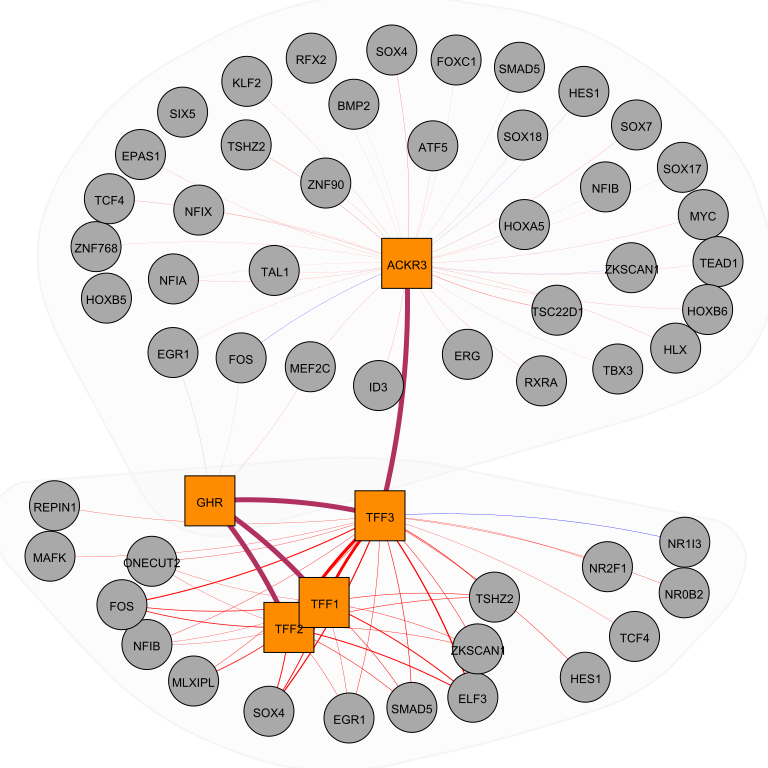

In [44]:
# 24, 26, 29, 35
g1 = vis.plot_pcNet(obj_T, view='sender', gene_names=[targets[1][0], targets[2][0], targets[5][0], targets[7][0]], 
                    top_edges=40, show = False, verbose = True)
g2 = vis.plot_pcNet(obj_T, view='receiver', gene_names=[targets[1][1], targets[2][1], targets[5][1], targets[7][1]], 
                    top_edges=40, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[1], targets[2], targets[5], targets[7]], 
              verbose = True, edge_width_scale=scale_factor)

In [45]:
g11 = vis.plot_pcNet(obj_N, view='sender', gene_names=[targets[1][0], targets[2][0], targets[5][0], targets[7][0]], 
              match_fig=g1, show = False, verbose = True, edge_width_scale=scale_factor)

g22 = vis.plot_pcNet(obj_N, view='receiver', gene_names=[targets[1][1], targets[2][1], targets[5][1], targets[7][1]], 
             match_fig=g2, show = False, verbose = True, edge_width_scale=scale_factor)

vis.plot_XNet(g11, g22, Xct_pair = [targets[1], targets[2], targets[5], targets[7]], verbose = True, edge_width_scale=scale_factor)

identified 139 TF(s) along with 4 ligand/receptor target gene(s)


ValueError: target gene TFF3 TFF3 TFF1 TFF2 generated 0 edge...

identified 138 TF(s) along with 4 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 38, # of edges: 73



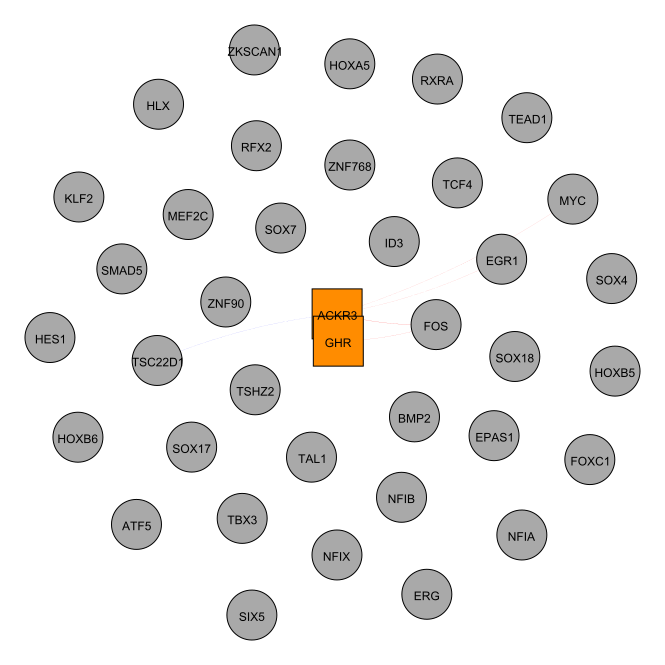

In [46]:
vis.plot_pcNet(obj_N, view='receiver', gene_names=[targets[1][1], targets[2][1], targets[5][1], targets[7][1]], 
             match_fig=g2, bbox_scale=1.3, show = True, verbose = True, edge_width_scale=scale_factor)

In [47]:
scale_factor = 50

identified 137 TF(s) along with 2 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

identified 138 TF(s) along with 2 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

graphs merged: 
# of nodes: 42, # of edges: 40

edge from IGF2 to PDGFRB added
edge from IGF2 to FGFR3 added


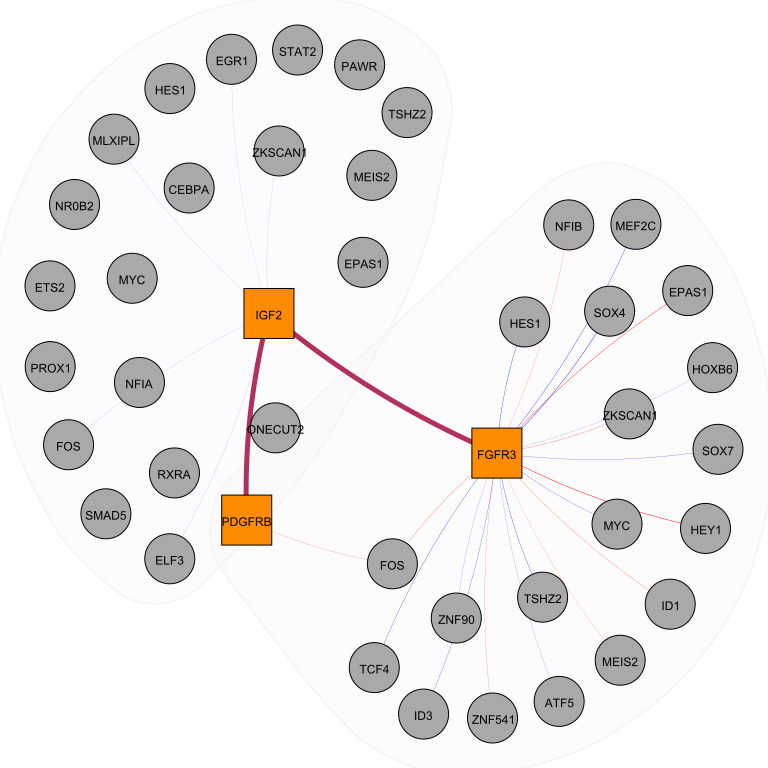

In [48]:
g1 = vis.plot_pcNet(obj_T, view='sender', gene_names=[targets[3][0], targets[6][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj_T, view='receiver', gene_names=[targets[3][1], targets[6][1]], top_edges=20, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[3], targets[6]], verbose = True, edge_width_scale=scale_factor)

identified 137 TF(s) along with 2 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 11

identified 138 TF(s) along with 2 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 39

graphs merged: 
# of nodes: 42, # of edges: 50

edge from IGF2 to PDGFRB added
edge from IGF2 to FGFR3 added


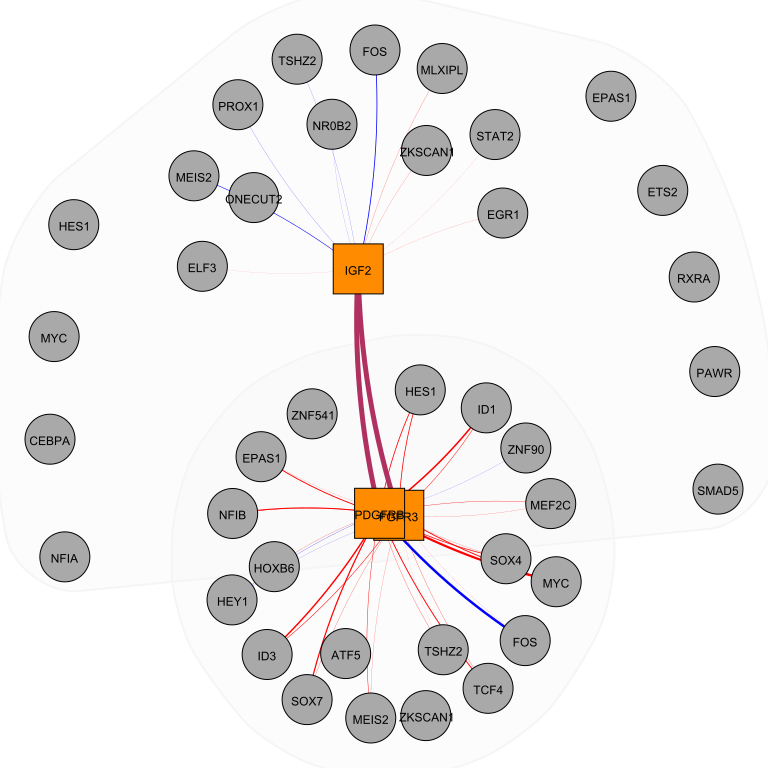

In [49]:
g11 = vis.plot_pcNet(obj_N, view='sender', gene_names=[targets[3][0], targets[6][0]], remove_isolated_nodes = False,
              match_fig=g1, show = False, verbose = True, edge_width_scale=scale_factor)

g22 = vis.plot_pcNet(obj_N, view='receiver', gene_names=[targets[3][1], targets[6][1]], 
             match_fig=g2, show = False, verbose = True, edge_width_scale=scale_factor)

vis.plot_XNet(g11, g22, Xct_pair = [targets[3], targets[6]], verbose = True, edge_width_scale=scale_factor)